In [69]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt


## 1. Préparation des données et des fonctions de plot

In [4]:
df_data = pd.read_csv('../data/train.csv')
df_data.head(1)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.0,0.00293,0.00293,0.035156,0.0,0.0,0.004883,0.0,0.025391


In [5]:
df_data.shape

(990, 194)

In [6]:
X = df_data.copy().drop(['id', 'species'],axis='columns').values

species = df_data['species'].unique()

# Création des vecteurs one-hot pour la matrice de targets
t = np.zeros(df_data.shape[0])
for i in range(species.size):
    t[df_data['species'] == species[i]] = i

In [7]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)

In [176]:
#création des listes des valeurs d'hyper-paramètres possibles
all_values_C_linear_poly = [1,2,3,4,5,6,7,8,9,10] ####################### revoir les valeurs à prendre ###################
all_values_C_rbf_sigmoid = np.logspace(0,1,20)
all_values_Gamma = np.logspace(-9, 0, 10)
all_values_Degree = [2,3,4,5,6,7,8,9,10]

In [66]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2), len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2), len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.semilogx(grid_param_1, scores_mean[idx, :], '-o', label=name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=10, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=10)
    ax.set_ylabel('CV Average Score', fontsize=10)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
    ax.grid('on')

In [153]:
def plot_grid_search_single_param(cv_results, grid_param, name_param, figsize=(10, 6)):
    # Get Test Scores Mean for each grid search
    scores_mean = cv_results['mean_test_score']

    # Plot the 2D curve
    plt.figure(figsize=figsize)
    plt.plot(grid_param, scores_mean, '-o')

    # Add labels and a title
    plt.xlabel(name_param)
    plt.ylabel('CV Average Score')
    plt.title("Grid Search Scores", fontsize=12, fontweight='bold')
    
    plt.grid(True)
    plt.show()

## 2. SVM linéaire
### 2.1 sans optimisation

In [40]:
classifieur_linear = svm.SVC(kernel='linear') # noyau lineaire
classifieur_linear.fit(X_train, t_train)

SVC(kernel='linear')

In [41]:
print("Score X_train, t_train : ", classifieur_linear.score(X_train, t_train))

Score X_train, t_train :  0.14285714285714285


### 2.2 optimisation des hyper-paramètres

In [144]:
# Paramètre à tester
param_grid_svm_linear= {
    'C' : all_values_C_linear_poly
}

# Création du modèle de recherche sur grille
grid_search_svm_linear = GridSearchCV(svm.SVC(kernel='linear'), param_grid_svm_linear, cv=5, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
grid_search_svm_linear.fit(X_train, t_train)
print('Done')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Done


In [145]:
results_grid_svm_linear = pd.DataFrame.from_dict(grid_search_svm_linear.cv_results_)
print(results_grid_svm_linear)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.166399      0.014824         0.054461        0.022180       1   
1       0.161519      0.011932         0.062463        0.026217       2   
2       0.174747      0.007794         0.039921        0.003149       3   
3       0.196486      0.025715         0.071443        0.017288       4   
4       0.203416      0.044835         0.068124        0.030361       5   
5       0.265666      0.059230         0.058561        0.013196       6   
6       0.246732      0.020402         0.047824        0.011548       7   
7       0.182902      0.022159         0.055242        0.011852       8   
8       0.180950      0.017356         0.063244        0.039681       9   
9       0.228579      0.058069         0.115363        0.058730      10   

      params  split0_test_score  split1_test_score  split2_test_score  \
0   {'C': 1}           0.100719           0.122302           0.100719   
1   {'C': 2}           0.179

In [146]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", grid_search_svm_linear.best_params_)
print("Meilleure précision:", grid_search_svm_linear.best_score_)

Meilleur paramètre: {'C': 10}
Meilleure précision: 0.7489104368678969


In [147]:
print('Score : ',grid_search_svm_linear.score(X_train,t_train))

Score :  0.9191919191919192


### 2.3 Visualisation de l'évolution de notre score selon l'évolution de nos hyper-paramètres

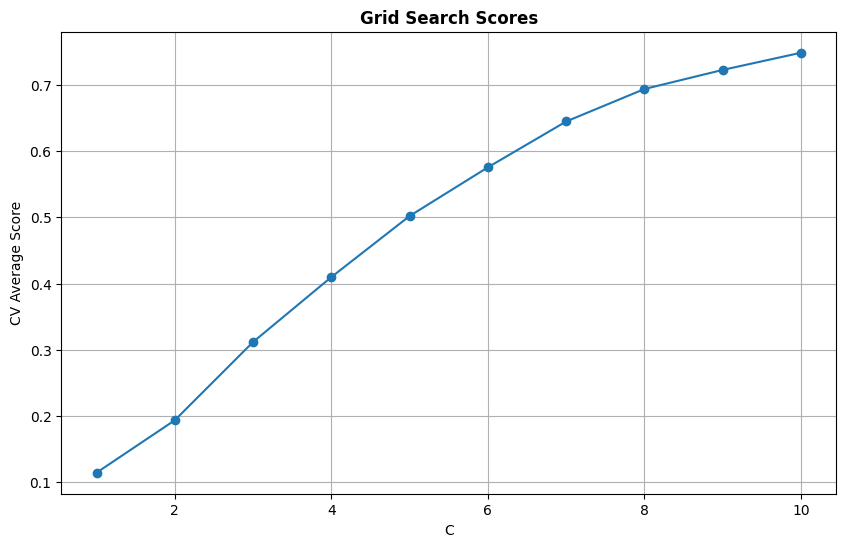

In [152]:
plot_grid_search_single_param(results_grid_svm_linear, all_values_C_linear_poly, 'C')

## 3. SVM noyau rbf
### 3.1 Sans optimisation

In [111]:
classifieur_rbf = svm.SVC(kernel='rbf',gamma=0.7) # noyau rbf 0.7 choisit de manière aléatoire
classifieur_rbf.fit(X_train, t_train)

SVC(gamma=0.7)

In [112]:
print("Score X_train, t_train : ", classifieur_rbf.score(X_train, t_train))

Score X_train, t_train :  0.18614718614718614


### 3.2 optimisation des hyper-paramètres

In [182]:
# Paramètre à tester
param_grid_svm_rbf= {
    'C' : all_values_C_rbf_sigmoid,
    'gamma' : all_values_Gamma
}

# Création du modèle de recherche sur grille
grid_search_svm_rbf = GridSearchCV(svm.SVC(kernel='rbf'), param_grid_svm_rbf, cv=5, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
grid_search_svm_rbf.fit(X_train, t_train)
print('Done')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Done


In [183]:
results_grid_svm_rbf = pd.DataFrame.from_dict(grid_search_svm_rbf.cv_results_)
print(results_grid_svm_rbf)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0         0.153427      0.007939         0.080208        0.013783     1.0   
1         0.173440      0.009801         0.082965        0.014823     1.0   
2         0.179806      0.023770         0.069378        0.009055     1.0   
3         0.229410      0.041486         0.117227        0.028314     1.0   
4         0.277669      0.058070         0.210992        0.112626     1.0   
..             ...           ...              ...             ...     ...   
195       0.214497      0.029114         0.062044        0.003702    10.0   
196       0.228819      0.044806         0.084426        0.012139    10.0   
197       0.203219      0.016384         0.070644        0.005201    10.0   
198       0.220901      0.014808         0.069376        0.010185    10.0   
199       0.214158      0.012919         0.053918        0.001851    10.0   

    param_gamma                        params  split0_test_score  \
0      

In [184]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", grid_search_svm_rbf.best_params_)
print("Meilleure précision:", grid_search_svm_rbf.best_score_)

Meilleur paramètre: {'C': 10.0, 'gamma': 1.0}
Meilleure précision: 0.8716087999165885


In [185]:
print('Score : ',grid_search_svm_rbf.score(X_train,t_train))

Score :  0.9797979797979798


### 3.3 Visualisation de l'évolution de notre score selon l'évolution de nos hyper-paramètres

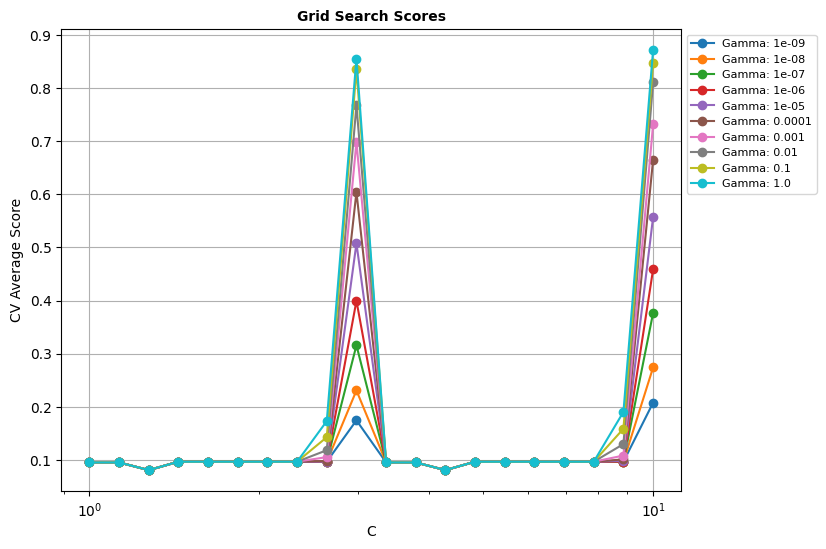

In [186]:
plot_grid_search(results_grid_svm_rbf, all_values_C_rbf_sigmoid, all_values_Gamma, 'C', 'Gamma')

## 4. SVM Noyau Polynomial
### 4.1 sans optimisation

In [52]:
classifieur_poly = svm.SVC(kernel='poly', degree=2, gamma="auto") # noyau rbf 0.7 choisit de manière aléatoire
classifieur_poly.fit(X_train, t_train)

SVC(degree=2, gamma='auto', kernel='poly')

In [53]:
print("Score X_train, t_train : ", classifieur_poly.score(X_train, t_train))

Score X_train, t_train :  0.07503607503607504


### 4.2 optimisation des hyper-paramètres

In [105]:
# Paramètre à tester
param_grid_svm_poly= {
    'C' : all_values_C_linear_poly,
    'degree' : all_values_Degree
}

# Création du modèle de recherche sur grille
grid_search_svm_poly = GridSearchCV(svm.SVC(kernel="poly", gamma="auto"), param_grid_svm_poly, cv=5, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
grid_search_svm_poly.fit(X_train, t_train)
print('Done')

Fitting 5 folds for each of 90 candidates, totalling 450 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Done


In [107]:
results_grid_svm_poly = pd.DataFrame.from_dict(grid_search_svm_poly.cv_results_)
print(results_grid_svm_poly)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.143326      0.013409         0.060280        0.023794       1   
1        0.336908      0.146163         0.080101        0.037493       1   
2        0.317239      0.103300         0.083130        0.020137       1   
3        0.333841      0.095359         0.077066        0.026646       1   
4        0.432113      0.064248         0.059896        0.017499       1   
..            ...           ...              ...             ...     ...   
85       0.247962      0.023442         0.054031        0.013427      10   
86       0.231748      0.031960         0.063308        0.012976      10   
87       0.263709      0.033237         0.070930        0.014821      10   
88       0.248472      0.030478         0.048356        0.022631      10   
89       0.199899      0.044200         0.025385        0.007970      10   

   param_degree                   params  split0_test_score  \
0             2    {'C':

In [108]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", grid_search_svm_poly.best_params_)
print("Meilleure précision:", grid_search_svm_poly.best_score_)

Meilleur paramètre: {'C': 1, 'degree': 2}
Meilleure précision: 0.08660202272964238


In [109]:
print('Score : ',grid_search_svm_poly.score(X_train,t_train))

Score :  0.07503607503607504


### 4.3 Visualisation de l'évolution de notre score selon l'évolution de nos hyper-paramètres

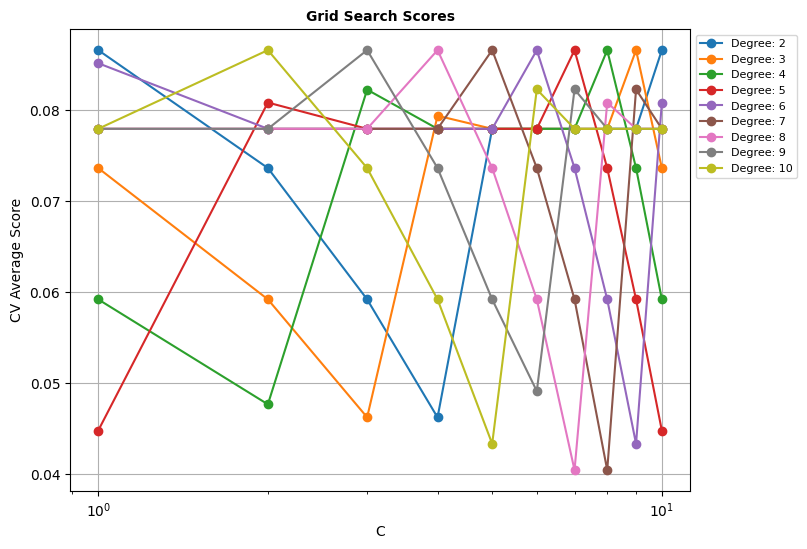

In [110]:
plot_grid_search(results_grid_svm_poly, all_values_C_linear_poly, all_values_Degree, 'C', 'Degree')

## 5. SVM Noyau Simoidal
### 5.1 sans optimisation

In [58]:
classifieur_sigmoid = svm.SVC(kernel='sigmoid', gamma=0.7) # noyau rbf 0.7 choisit de manière aléatoire
classifieur_sigmoid.fit(X_train, t_train)

SVC(gamma=0.7, kernel='sigmoid')

In [59]:
print("Score X_train, t_train : ", classifieur_sigmoid.score(X_train, t_train))

Score X_train, t_train :  0.10101010101010101


### 5.2 optimisation des hyper-paramètres

In [177]:
# Paramètre à tester
param_grid_svm_sigmoid= {
    'C' : all_values_C_rbf_sigmoid,
    'gamma' : all_values_Gamma
}

# Création du modèle de recherche sur grille
grid_search_svm_sigmoid = GridSearchCV(svm.SVC(kernel="sigmoid"), param_grid_svm_sigmoid, cv=5, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
grid_search_svm_sigmoid.fit(X_train, t_train)
print('Done')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Done


In [178]:
results_grid_svm_sigmoid = pd.DataFrame.from_dict(grid_search_svm_sigmoid.cv_results_)
print(results_grid_svm_sigmoid)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0         0.143862      0.008387         0.039627        0.006492     1.0   
1         0.169630      0.016267         0.050752        0.023399     1.0   
2         0.185398      0.019784         0.039263        0.004941     1.0   
3         0.186147      0.025177         0.075522        0.043172     1.0   
4         0.192346      0.030906         0.047394        0.002715     1.0   
..             ...           ...              ...             ...     ...   
195       0.201969      0.018852         0.044054        0.004926    10.0   
196       0.179076      0.013459         0.041717        0.003729    10.0   
197       0.193940      0.023753         0.039960        0.004585    10.0   
198       0.190614      0.024151         0.042795        0.005534    10.0   
199       0.178155      0.010670         0.033972        0.005113    10.0   

    param_gamma                        params  split0_test_score  \
0      

In [179]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", grid_search_svm_sigmoid.best_params_)
print("Meilleure précision:", grid_search_svm_sigmoid.best_score_)

Meilleur paramètre: {'C': 10.0, 'gamma': 1.0}
Meilleure précision: 0.7460223125847149


In [180]:
print('Score : ',grid_search_svm_sigmoid.score(X_train,t_train))

Score :  0.9163059163059163


### 5.3 Visualisation de l'évolution de notre score selon l'évolution de nos hyper-paramètres

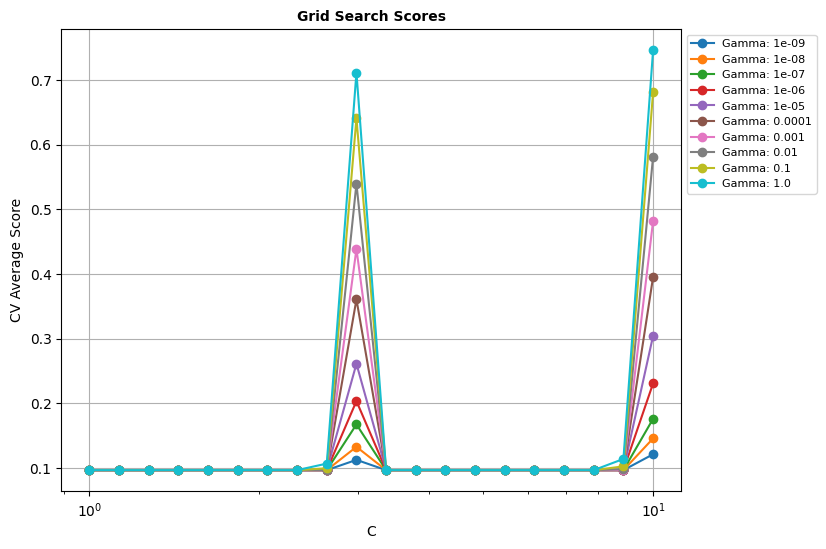

In [181]:
plot_grid_search(results_grid_svm_sigmoid, all_values_C_rbf_sigmoid, all_values_Gamma, 'C', 'Gamma')